In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

### Loading data from workspace

In [3]:
train_data = pd.read_csv('../input/sign_mnist_train.csv') 
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [4]:
test_data = pd.read_csv('../input/sign_mnist_test.csv') 
test_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,152,152,152,152,152,153,153,151,152,152,153,152,152,151,151,150,150,150,149,150,150,150,152,152,151,152,152,152,152,152,...,131,134,144,147,125,87,87,103,107,110,116,113,75,74,74,74,76,74,82,134,168,155,146,137,145,146,149,135,124,125,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,138,137,137,138,138,139,137,142,140,138,139,137,137,136,135,134,133,134,132,129,132,134,135,135,137,139,139,139,140,141,...,114,112,89,48,133,194,182,185,184,184,182,181,172,174,177,178,178,179,181,183,187,175,165,154,118,107,100,75,96,83,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,152,157,163,168,171,182,172,175,185,183,184,185,185,185,183,183,182,181,178,86,88,93,96,108,125,137,145,149,154,160,...,145,123,78,162,239,227,229,226,226,225,224,222,89,91,94,111,136,154,167,184,125,3,166,225,195,188,172,185,161,122,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,209,208,207,207,209,208,210,210,207,209,209,208,209,210,209,207,208,209,207,206,208,209,208,208,210,211,210,211,209,209,...,85,80,84,151,238,255,255,250,237,245,250,232,103,101,102,103,95,208,231,227,209,190,179,182,152,150,159,119,83,63,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,203,204,204,204,203,202,198,216,217,135,181,200,195,194,193,190,189,187,185,190,194,196,197,200,202,204,206,207,207,206,...,93,52,24,53,63,33,41,51,48,45,49,55,149,150,150,148,147,151,124,82,84,81,69,81,111,103,84,75,53,28,26,40,64,48,29,46,49,46,46,53


### Creating data-sets

In [5]:
X_train = train_data.drop(columns='label').values
y_train = train_data['label'].values

In [6]:
X_test = test_data.drop(columns='label').values
y_test = test_data['label'].values

In [7]:
X_train = X_train.reshape(len(X_train),28,28,1)
X_test = X_test.reshape(len(X_test),28,28,1)

In [8]:
# data normalization

X_train = X_train / 255.
X_test = X_test / 255.

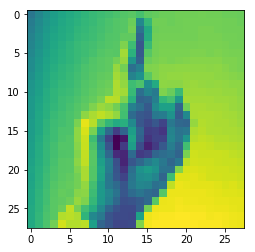

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(X_train[0].reshape(28,28))

In [10]:
from tensorflow import keras
from keras.utils import to_categorical

Using TensorFlow backend.


In [11]:
# one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [16]:
# define some callbacks

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

class my_max_acc_callback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

# my max accuracy callback
my_mxaccb = my_max_acc_callback()

# checkpoint for best weights
filepath='model-best-weights.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')

# early stopping
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True)

# reducing_Learning_Rate
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='auto')

#collecting all callbacks
callbacks_list = [my_mxaccb, checkpoint, earlyStopping, reduce_lr_loss]

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

# create model
model = Sequential()

#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
model.add(MaxPooling2D(2,2))
#
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(2,2))
#
model.add(Dense(256,activation='relu'))
#
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(2,2))
#
model.add(Flatten())
model.add(Dropout(0.2))
#
model.add(Dense(256,activation='relu'))
model.add(Dense(25, activation='softmax'))

model.summary()

model.compile(
    loss = 'categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dense_4 (Dense)              (None, 5, 5, 256)         16640     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          147520    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 64)          0         
__________

In [18]:
history = model.fit(
    X_train, 
    y_train,
    validation_split=0.3,
    epochs=50,
    verbose=1,
    callbacks=callbacks_list)

Train on 19218 samples, validate on 8237 samples
Epoch 1/50
19218/19218 [==============================] - 5s 250us/step - loss: 2.0508 - acc: 0.3405 - val_loss: 0.8336 - val_acc: 0.7410

Epoch 00001: val_acc improved from -inf to 0.74105, saving model to model-best-weights.hdf5
Epoch 2/50
19218/19218 [==============================] - 4s 214us/step - loss: 0.8453 - acc: 0.7097 - val_loss: 0.4801 - val_acc: 0.8354

Epoch 00002: val_acc improved from 0.74105 to 0.83538, saving model to model-best-weights.hdf5
Epoch 3/50
19218/19218 [==============================] - 4s 213us/step - loss: 0.5322 - acc: 0.8172 - val_loss: 0.2124 - val_acc: 0.9523

Epoch 00003: val_acc improved from 0.83538 to 0.95229, saving model to model-best-weights.hdf5
Epoch 4/50
19218/19218 [==============================] - 4s 216us/step - loss: 0.3886 - acc: 0.8665 - val_loss: 0.1151 - val_acc: 0.9744

Epoch 00004: val_acc improved from 0.95229 to 0.97438, saving model to model-best-weights.hdf5
Epoch 5/50
19218/1

<Figure size 432x288 with 0 Axes>

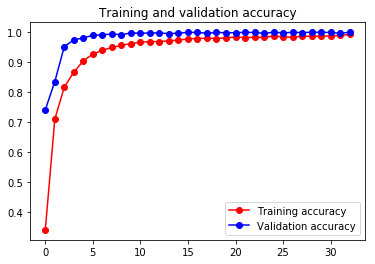

<Figure size 432x288 with 0 Axes>

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro-', label='Training accuracy')
plt.plot(epochs, val_acc, 'bo-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

<Figure size 432x288 with 0 Axes>

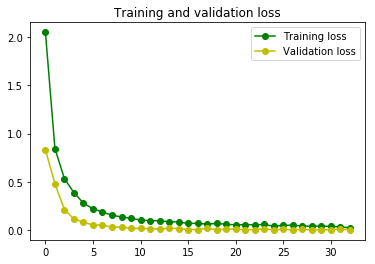

<Figure size 432x288 with 0 Axes>

In [20]:
plt.plot(epochs, loss, 'go-', label='Training loss')
plt.plot(epochs, val_loss, 'yo-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

In [21]:
# testing model on test set
test_loss = model.evaluate(X_test, y_test)
print(model.metrics_names)
print(test_loss)

7172/7172 [==============================] - 1s 74us/step
['loss', 'acc']
[0.25022199526632727, 0.9307027328499721]
